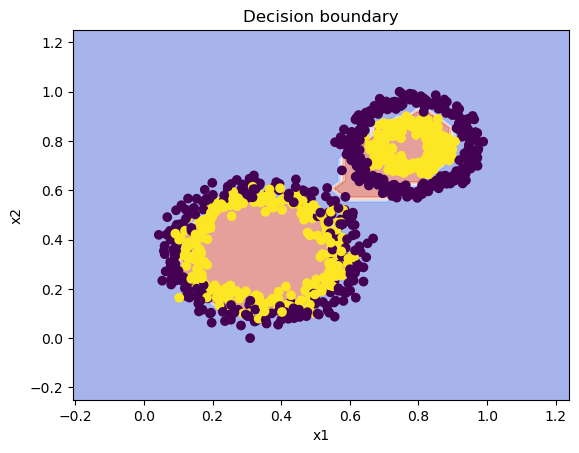

In [1]:
from dice_wrapper import *
from robx import *
from create_data_examples import *
from scikit_models import *
from plot_helpers import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

np.random.seed(222)

# Ignore InconsistentVersionWarning
warnings.filterwarnings("ignore", category=UserWarning)

X_train, y_train = create_two_donuts(n_samples=1000, random_state=0)
X_val, y_val = create_two_donuts(n_samples=500, random_state=1)
X_test, y_test = create_two_donuts(n_samples=500, random_state=2)

train_dataset = pd.DataFrame(np.concatenate([X_train, y_train.reshape(-1, 1)], axis=1), columns=['x1', 'x2', 'y'])
train_dataset['y'] = train_dataset['y'].astype(int)

val_dataset = pd.DataFrame(np.concatenate([X_val, y_val.reshape(-1, 1)], axis=1), columns=['x1', 'x2', 'y'])
val_dataset['y'] = val_dataset['y'].astype(int)

test_dataset = pd.DataFrame(np.concatenate([X_test, y_test.reshape(-1, 1)], axis=1), columns=['x1', 'x2', 'y'])
test_dataset['y'] = test_dataset['y'].astype(int)

model_name = 'mlp'
model = load_model(f'../models/{model_name}.joblib')


plot_crisp_decision_boundary(model, X_val, y_val)

In [2]:
explainer = get_dice_explainer(
    dataset=train_dataset,
    model=model,
    outcome_name='y',
    continous_features=['x1', 'x2'],
    dice_method='random',
)


original_instances = []
counterfactuals = []

for i in range(3):
    cf = get_dice_counterfactuals(
            dice_exp=explainer,
            query_instance=val_dataset.iloc[i:i+1].drop(columns=['y']),
            total_CFs=1,
            proximity_weight=1.0,
            diversity_weight=0.1,
            # desired_class="opposite",
        )
    original_instances.append(val_dataset.iloc[i:i+1].to_numpy()[0])
    counterfactuals.append(cf[0].final_cfs_df.to_numpy()[0])

100%|██████████| 1/1 [00:00<00:00,  5.77it/s]


In [3]:
print(original_instances)
print(counterfactuals)

[array([0.41994346, 0.58137208, 1.        ]), array([0.25554954, 0.49508711, 1.        ]), array([0.46285942, 0.60038694, 0.        ])]
[array([0.37021892, 0.58137208, 1.        ]), array([0.95988133, 0.49508711, 0.        ]), array([0.46285942, 0.19416374, 1.        ])]


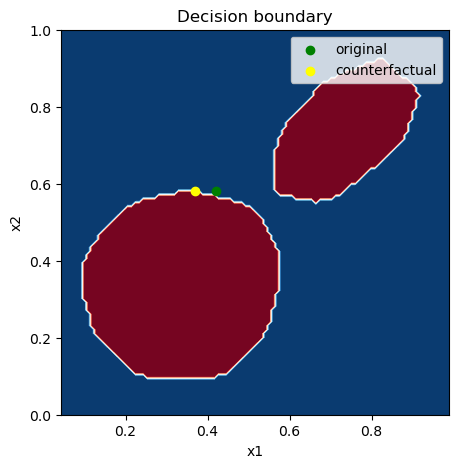

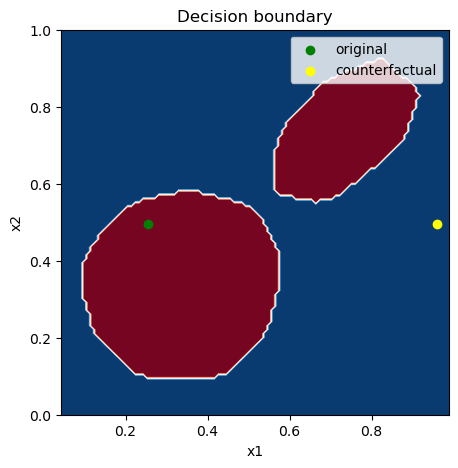

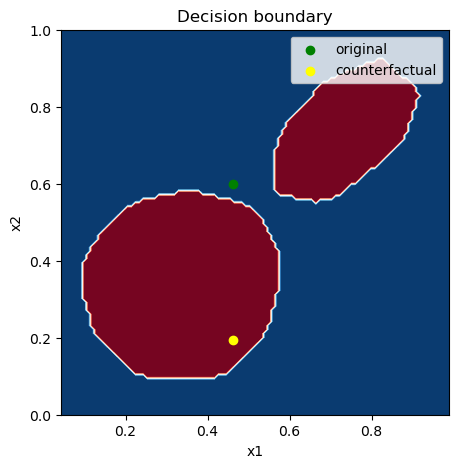

In [4]:


for i in range(3):
    plot_decision_boundary_with_artifacts(
        model=model,
        X=X_val,
        y=y_val,
        artifacts=[
            {'coords': original_instances[i][:2], 'color': 'green', 'marker': 'o', 'label': 'original'},
            {'coords': counterfactuals[i][:2], 'color': 'yellow', 'marker': 'o', 'label': 'counterfactual'},
        ]
    )

original proba [0.40909493]
counterfactual proba [0.47068486]
robust_cf proba [0.36043745]
--------


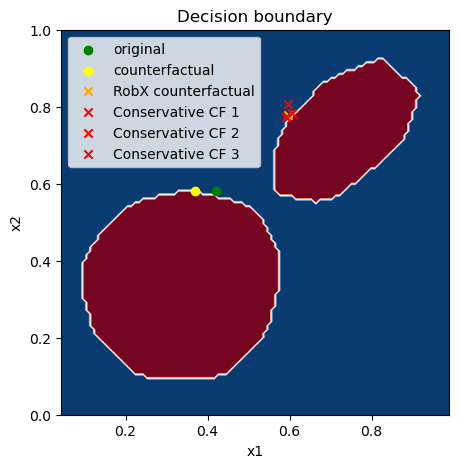

original proba [0.92659178]
counterfactual proba [2.00470226e-05]
robust_cf proba [3.39122245e-05]
--------


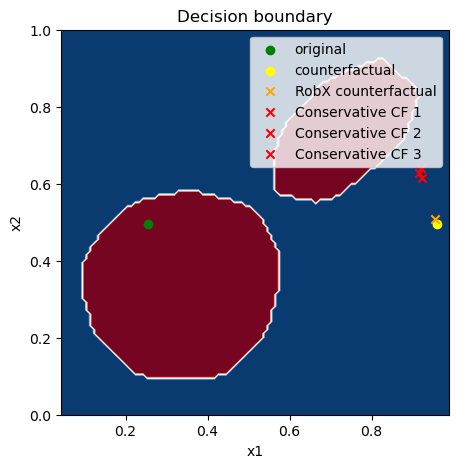

Counterfactual stability history: [-0.13440462002794026, -0.1353053933916722, -0.1227920696122134, -0.16056863335623958, -0.09899642747772847, -0.14238437183641334, -0.12357479848336506, -0.17605225695710233, -0.13087964067606497, -0.10533475475129722, -0.14396792491449084, -0.13523030514460224, -0.145456685296962, -0.09174895850475162, -0.12853934992189586, -0.15215568032247803, -0.12640910687004048, -0.13867061854998625, -0.1261635511539783, -0.112967262425828, -0.17796744659088606, -0.13786317912101645, -0.13629826910441867, -0.17787955947073902, -0.14264950847614252, -0.14893648474385743, -0.14179320317917488, -0.11630662516830231, -0.1331887215565201, -0.15793926226437147, -0.16121991153162782, -0.12440204640407748, -0.09571056740339717, -0.13801686349484701, -0.1742345280030181, -0.15339957144922525, -0.14775770813162503, -0.12204637227531573, -0.14250914190457256, -0.14801849072407025, -0.10478216453488065, -0.14235073395421427, -0.14996011742991006, -0.1315403917550448, -0.1470

AttributeError: 'NoneType' object has no attribute 'reshape'

In [12]:
predict_fn = scikit_predict_proba_fn(model)

for i in range(3):
    
    orig = original_instances[i][:2].reshape(1, -1)
    cf = counterfactuals[i][:2].reshape(1, -1)

    robust_cf, conservative_cfs = robx_algorithm(
        X_train=X_train,
        predict_class_proba_fn=predict_fn,
        start_counterfactual=counterfactuals[i][:2],
        tau=0.6,
        variance=0.1,
    )
    robust_cf = robust_cf.reshape(1, -1)
    
    if robust_cf is not None:
        art = [
                {'coords': orig.flatten(), 'color': 'green', 'marker': 'o', 'label': 'original'},
                {'coords': cf.flatten(), 'color': 'yellow', 'marker': 'o', 'label': 'counterfactual'},
                {'coords': robust_cf.flatten(), 'color': 'orange', 'marker': 'x', 'label': 'RobX counterfactual'}, 
            ]
        if conservative_cfs is not None: # if conservative_cfs is not None
            for i, ccf in enumerate(conservative_cfs):
                art.append({'coords': ccf, 'color': 'red', 'marker': 'x', 'label': f'Conservative CF {i+1}'})
        
    print(f'original proba {predict_fn(orig)}')
    print(f'counterfactual proba {predict_fn(cf)}')
    print(f'robust_cf proba {predict_fn(robust_cf)}')
    print('--------')
    
    plot_decision_boundary_with_artifacts(
        model=model,
        X=X_val,
        y=y_val,
        artifacts=art,
    )
        

In [ ]:
predict_fn(np.array([0.3, 0.8]).reshape(1, -1))

array([7.74896037e-05])

In [10]:
0.1 ** 0.5

0.31622776601683794